### Stellar Classification Using Logistic Regression of Spectral Characteristics

By Jenica Andersen

This project aims to classify observations of stellar objects into three categories: Star, Galaxy, or Quasar (an active galactic nucleus). Initial work will be done using binary classification, first including Star and Galaxy, then work will be expanded to include Quasar. Three models will be created and tested for best performance, Logistic Regression, kNN, and Random Forest.
The dataset is available on [Kaggle.com](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17) 


In this notebook, I:

1. Obtain, import, explore, visualize, and clean the data 
    - Set object ID as string
    - remove row with null (-9999) values
    - remove unnecessary columns
    - remove QSO rows
    - create binary class int column
2. Split the data into 70% training data and 30% testing data using train-test-split. 
5. Determine the metrics used to evaluate each model performance. (roc_auc, precision, recall, f1, )
3. Establish pipeline (separate one for each model) that includes scaling the data and running KNN, Logistic Regression and Random Forest.
4. Perform RandomizedSearchCV initially, then GridSearchCV via the pipeline, preprocess, validate and tune the parameters
5. train the best model + parameters on all of the data. Test on the hold out data
6. Visialize results (confusion matrix heatmap, ROC AUC curve)
7. Run multiclass and other experiments of interest
8. Report results!


In [2]:
#Bring in the data munging tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

#Bring in the SciKit-Learn tools needed to pocress, model, and validate the data
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, r2_score, 
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest

**1. Obtain, import, explore, visualize, and clean the [data](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17)**

In [104]:
#import the downloaded dataset
df = pd.read_csv (r'star_classification.csv')

In [105]:
#take a look at the data
df.head()

obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3  1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4  1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301        2        79  6.543777e+18   
1  21.16812  21.61427    4518       301        5       119  1.176014e+19   
2  19.34857  18.94827    3606       301        2       120  5.152200e+18   
3  20.50454  19.25010    4192       301        3       214  1.030107e+19   
4  15.97711  15.54461    8102       301        3       137  6.891865e+18   

    class  redshift  plate    MJD  fiber_ID  
0  GALAXY  0.634794   5812  56354       171  
1  GALAXY  0.779136  10445  58158       427  
2  GALAXY  0.644195   4576  55592       299  
3  GALAXY  0.932346   9149  58039       775  
4  GALAXY  0.116123   6121  56187       842

In [106]:
#Is the data balanced? It looks like it is not great, but not too bad. We may want to test that. 
df.value_counts('class')

class
GALAXY    59445
STAR      21594
QSO       18961
dtype: int64

In [107]:
#look at the data info. No nulls. obj_ID should be treated as a string. Nothing else major stands out. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [108]:
#Look closer at the data. 
df.describe()

obj_ID          alpha          delta              u  \
count  1.000000e+05  100000.000000  100000.000000  100000.000000   
mean   1.237665e+18     177.629117      24.135305      21.980468   
std    8.438560e+12      96.502241      19.644665      31.769291   
min    1.237646e+18       0.005528     -18.785328   -9999.000000   
25%    1.237659e+18     127.518222       5.146771      20.352353   
50%    1.237663e+18     180.900700      23.645922      22.179135   
75%    1.237668e+18     233.895005      39.901550      23.687440   
max    1.237681e+18     359.999810      83.000519      32.781390   

                   g              r              i              z  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       20.531387      19.645762      19.084854      18.668810   
std        31.750292       1.854760       1.757895      31.728152   
min     -9999.000000       9.822070       9.469903   -9999.000000   
25%        18.965230      18.135828      17.732285      17.460677   
50%        21.099835      20.125290      19.405145      19.004595   
75%        22.123767      21.044785      20.396495      19.921120   
max        31.602240      29.571860      32.141470      29.383740   

              run_ID  rerun_ID        cam_col       field_ID   spec_obj_ID  \
count  100000.000000  100000.0  100000.000000  100000.000000  1.000000e+05   
mean     4481.366060     301.0       3.511610     186.130520  5.783882e+18   
std      1964.764593       0.0       1.586912     149.011073  3.324016e+18   
min       109.000000     301.0       1.000000      11.000000  2.995191e+17   
25%      3187.000000     301.0       2.000000      82.000000  2.844138e+18   
50%      4188.000000     301.0       4.000000     146.000000  5.614883e+18   
75%      5326.000000     301.0       5.000000     241.000000  8.332144e+18   
max      8162.000000     301.0       6.000000     989.000000  1.412694e+19   

            redshift          plate            MJD       fiber_ID  
count  100000.000000  100000.000000  100000.000000  100000.000000  
mean        0.576661    5137.009660   55588.647500     449.312740  
std         0.730707    2952.303351    1808.484233     272.498404  
min        -0.009971     266.000000   51608.000000       1.000000  
25%         0.054517    2526.000000   54234.000000     221.000000  
50%         0.424173    4987.000000   55868.500000     433.000000  
75%         0.704154    7400.250000   56777.000000     645.000000  
max         7.011245   12547.000000   58932.000000    1000.000000

#### The *min* looks suspicious in some columns!

In [109]:
df.sort_values('u', ascending = True)

obj_ID       alpha      delta           u           g         r  \
79543  1.237649e+18  224.006526  -0.624304 -9999.00000 -9999.00000  18.16560   
57763  1.237665e+18  208.358688  33.825699    10.99623    13.66217  12.35763   
75784  1.237662e+18  239.473361  27.594369    12.10168    10.49820  10.11604   
4472   1.237662e+18  239.423127  28.548438    12.26240    10.51139  10.06854   
75620  1.237662e+18  239.207155  27.898444    12.30349    10.67180  10.19460   
...             ...         ...        ...         ...         ...       ...   
1046   1.237679e+18    0.115997  22.714164    29.19901    25.35543  23.48086   
20225  1.237664e+18   19.689708  -1.058819    29.23438    25.40505  17.51251   
19525  1.237658e+18  125.737753  33.875543    29.32565    20.29043  18.35283   
21245  1.237664e+18   22.566355   0.950467    30.66039    30.60700  29.37411   
56693  1.237661e+18  120.265645  23.563929    32.78139    14.15644  13.36123   

              i           z  run_ID  rerun_ID  cam_col  field_ID  \
79543  18.01675 -9999.00000     752       301        2       537   
57763  12.63744    11.30247    4552       301        6       229   
75784  10.00865    10.44131    3919       301        3       235   
4472   13.41786    10.22551    3927       301        4        79   
75620  10.05509    10.65056    3919       301        3       233   
...         ...         ...     ...       ...      ...       ...   
1046   21.56495    17.17135    7917       301        4       105   
20225  16.55034    23.54460    4263       301        1       247   
19525  17.85217    26.13011    2830       301        4       116   
21245  30.25009    16.82299    4263       301        6       266   
56693  26.30939    13.76284    3605       301        4        74   

        spec_obj_ID   class  redshift  plate    MJD  fiber_ID  
79543  3.731277e+18    STAR  0.000089   3314  54970       162  
57763  2.383624e+18     QSO  3.955592   2117  54115       342  
75784  3.383405e+18    STAR  0.000008   3005  54876       274  
4472   3.383435e+18    STAR  0.000025   3005  54876       384  
75620  3.383416e+18    STAR  0.000003   3005  54876       316  
...             ...     ...       ...    ...    ...       ...  
1046   8.630148e+18     QSO  0.253981   7665  57328       455  
20225  9.896750e+18    STAR -0.000167   8790  57363       328  
19525  5.001404e+18  GALAXY  0.503306   4442  55532       568  
21245  8.802546e+18    STAR -0.000456   7818  56989       947  
56693  1.423298e+18     QSO  1.658421   1264  52707       584  

[100000 rows x 18 columns]

#### It looks like one row needs to be removed because the data seem incomplete in that row.

In [110]:
#Remove the unusual row
df = df[df.u >0]
df.describe()

obj_ID         alpha         delta             u             g  \
count  9.999900e+04  99999.000000  99999.000000  99999.000000  99999.000000   
mean   1.237665e+18    177.628653     24.135552     22.080679     20.631583   
std    8.438450e+12     96.502612     19.644608      2.251068      2.037384   
min    1.237646e+18      0.005528    -18.785328     10.996230     10.498200   
25%    1.237659e+18    127.517698      5.147477     20.352410     18.965240   
50%    1.237663e+18    180.900527     23.646462     22.179140     21.099930   
75%    1.237668e+18    233.895005     39.901582     23.687480     22.123775   
max    1.237681e+18    359.999810     83.000519     32.781390     31.602240   

                  r             i             z        run_ID  rerun_ID  \
count  99999.000000  99999.000000  99999.000000  99999.000000   99999.0   
mean      19.645777     19.084865     18.768988   4481.403354     301.0   
std        1.854763      1.757900      1.765982   1964.739021       0.0   
min        9.822070      9.469903      9.612333    109.000000     301.0   
25%       18.135795     17.732280     17.460830   3187.000000     301.0   
50%       20.125310     19.405150     19.004600   4188.000000     301.0   
75%       21.044790     20.396510     19.921120   5326.000000     301.0   
max       29.571860     32.141470     29.383740   8162.000000     301.0   

            cam_col      field_ID   spec_obj_ID      redshift         plate  \
count  99999.000000  99999.000000  9.999900e+04  99999.000000  99999.000000   
mean       3.511625    186.127011  5.783903e+18      0.576667   5137.027890   
std        1.586913    149.007687  3.324026e+18      0.730709   2952.312485   
min        1.000000     11.000000  2.995191e+17     -0.009971    266.000000   
25%        2.000000     82.000000  2.844137e+18      0.054522   2526.000000   
50%        4.000000    146.000000  5.614896e+18      0.424176   4987.000000   
75%        5.000000    241.000000  8.332365e+18      0.704172   7400.500000   
max        6.000000    989.000000  1.412694e+19      7.011245  12547.000000   

                MJD      fiber_ID  
count  99999.000000  99999.000000  
mean   55588.653687    449.315613  
std     1808.492217    272.498252  
min    51608.000000      1.000000  
25%    54234.000000    221.000000  
50%    55869.000000    433.000000  
75%    56777.000000    645.000000  
max    58932.000000   1000.000000

#### Column descriptions from data source
* obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
* alpha = Right Ascension angle (at J2000 epoch)
* delta = Declination angle (at J2000 epoch)
* u = Ultraviolet filter in the photometric system
* g = Green filter in the photometric system
* r = Red filter in the photometric system
* i = Near Infrared filter in the photometric system
* z = Infrared filter in the photometric system
* run_ID = Run Number used to identify the specific scan
* rereun_ID = Rerun Number to specify how the image was processed
* cam_col = Camera column to identify the scanline within the run
* field_ID = Field number to identify each field
* spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
* class = object class (galaxy, star or quasar object)
* redshift = redshift value based on the increase in wavelength
* plate = plate ID, identifies each plate in SDSS
* MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
* fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation


#### An individual sample/unit is an observed stellar object and its spectral characteristics. 

#### The target will be **class** (object class--galaxy, star or quasar object)

**Some columns appear to be irrelevant to classification, at first glance (and at closer glance, not represented in this code)** 
*obj_ID, run_ID, rerun_ID, cam_col, spec_obj_ID, MJD* are all going to be excluded from the model at this stage

In [119]:
# Limit df to columns of interest
df = df[['alpha','delta', 'u', 'g', 'r', 'i', 'z', 'field_ID', 'plate', 'fiber_ID', 'redshift','class']]

In [120]:
#Add integer target class column 

#Create a dictionary to map the three values to new column
classes_dict = {'STAR' : 1, 'GALAXY' : 0, 'QSO' : -1}

#create new column
df['target_class'] = df['class'].map(classes_dict)

#view result
df.sample(20)

alpha      delta         u         g         r         i  \
39744  201.191800  34.701702  21.42948  20.90695  20.55407  20.32285   
89074  227.625568  57.321607  22.17686  20.14265  18.52087  17.90134   
13299  354.362376  17.658730  20.39122  20.32500  20.22742  20.00545   
31112  125.176657  46.728396  21.71220  19.42918  18.21544  17.64575   
84888  219.920210  38.402485  22.79362  22.14391  22.01393  21.98208   
17884  256.536634  39.626998  20.61013  19.05840  18.46312  18.22491   
85479  143.709784  54.792309  21.27995  19.29094  20.17625  18.69499   
74594  324.609923   9.809116  22.50116  20.22080  18.75200  18.06055   
73828   19.056053   9.053525  21.62978  21.51299  19.60304  18.86537   
18386  129.671390  11.332124  25.68825  21.73130  20.18975  19.33544   
17081   28.415476   0.968126  24.11758  23.37998  21.59321  21.09268   
23403  185.978401  37.611601  22.25641  21.75129  21.66285  21.47334   
22737  192.301119  34.547083  23.13950  22.12699  20.56730  19.54477   
77902  152.779165  39.878125  22.74834  22.06693  21.98988  22.03028   
43540  206.034763  35.405004  19.34119  17.49328  16.70374  16.29881   
99797  147.954032  20.101859  22.64091  22.52714  21.68870  21.41658   
511    157.458305  44.496612  20.47094  18.60859  17.88211  17.59633   
93587  135.687822  19.468903  21.92753  27.89482  26.69312  21.95783   
60915  117.261478  18.325241  20.60497  19.53053  19.07958  18.92570   
29976  254.708299  33.161795  19.11944  17.20422  16.31594  15.89200   

              z  field_ID  plate  fiber_ID  redshift   class  target_class  
39744  19.91119       189   3982       696  2.030074     QSO            -1  
89074  17.51875        22    612       437  0.271896  GALAXY             0  
13299  19.88222       121   7602       172  1.879820     QSO            -1  
31112  17.25196       144   7325       527 -0.000048    STAR             1  
84888  21.31116       405  10750       599  2.463926     QSO            -1  
17884  18.13837        65   2192       637 -0.000109    STAR             1  
85479  19.60752       156   5710       371  0.000049    STAR             1  
74594  17.75773        78   4093       655  0.263373  GALAXY             0  
73828  18.45231       322   4555       300  0.420585  GALAXY             0  
18386  18.85724        88   5284       794  0.504830  GALAXY             0  
17081  20.98740       305   9390       734  0.383816     QSO            -1  
23403  20.94638        22   8866       752  1.682763     QSO            -1  
22737  19.13671       488   3971        75  0.583220  GALAXY             0  
77902  22.35714        38   8826       568  1.308231  GALAXY             0  
43540  16.03859        61   2028       327  0.059459  GALAXY             0  
99797  20.24348       232   9579       419  0.639537  GALAXY             0  
511    17.43945       258   2567       433  0.000069    STAR             1  
93587  21.26449       144   5769       580  1.530559     QSO            -1  
60915  18.83765        39   2074       621 -0.000109    STAR             1  
29976  15.55062       109    972       216  0.061974  GALAXY             0

## Explore the data with a pairplot.

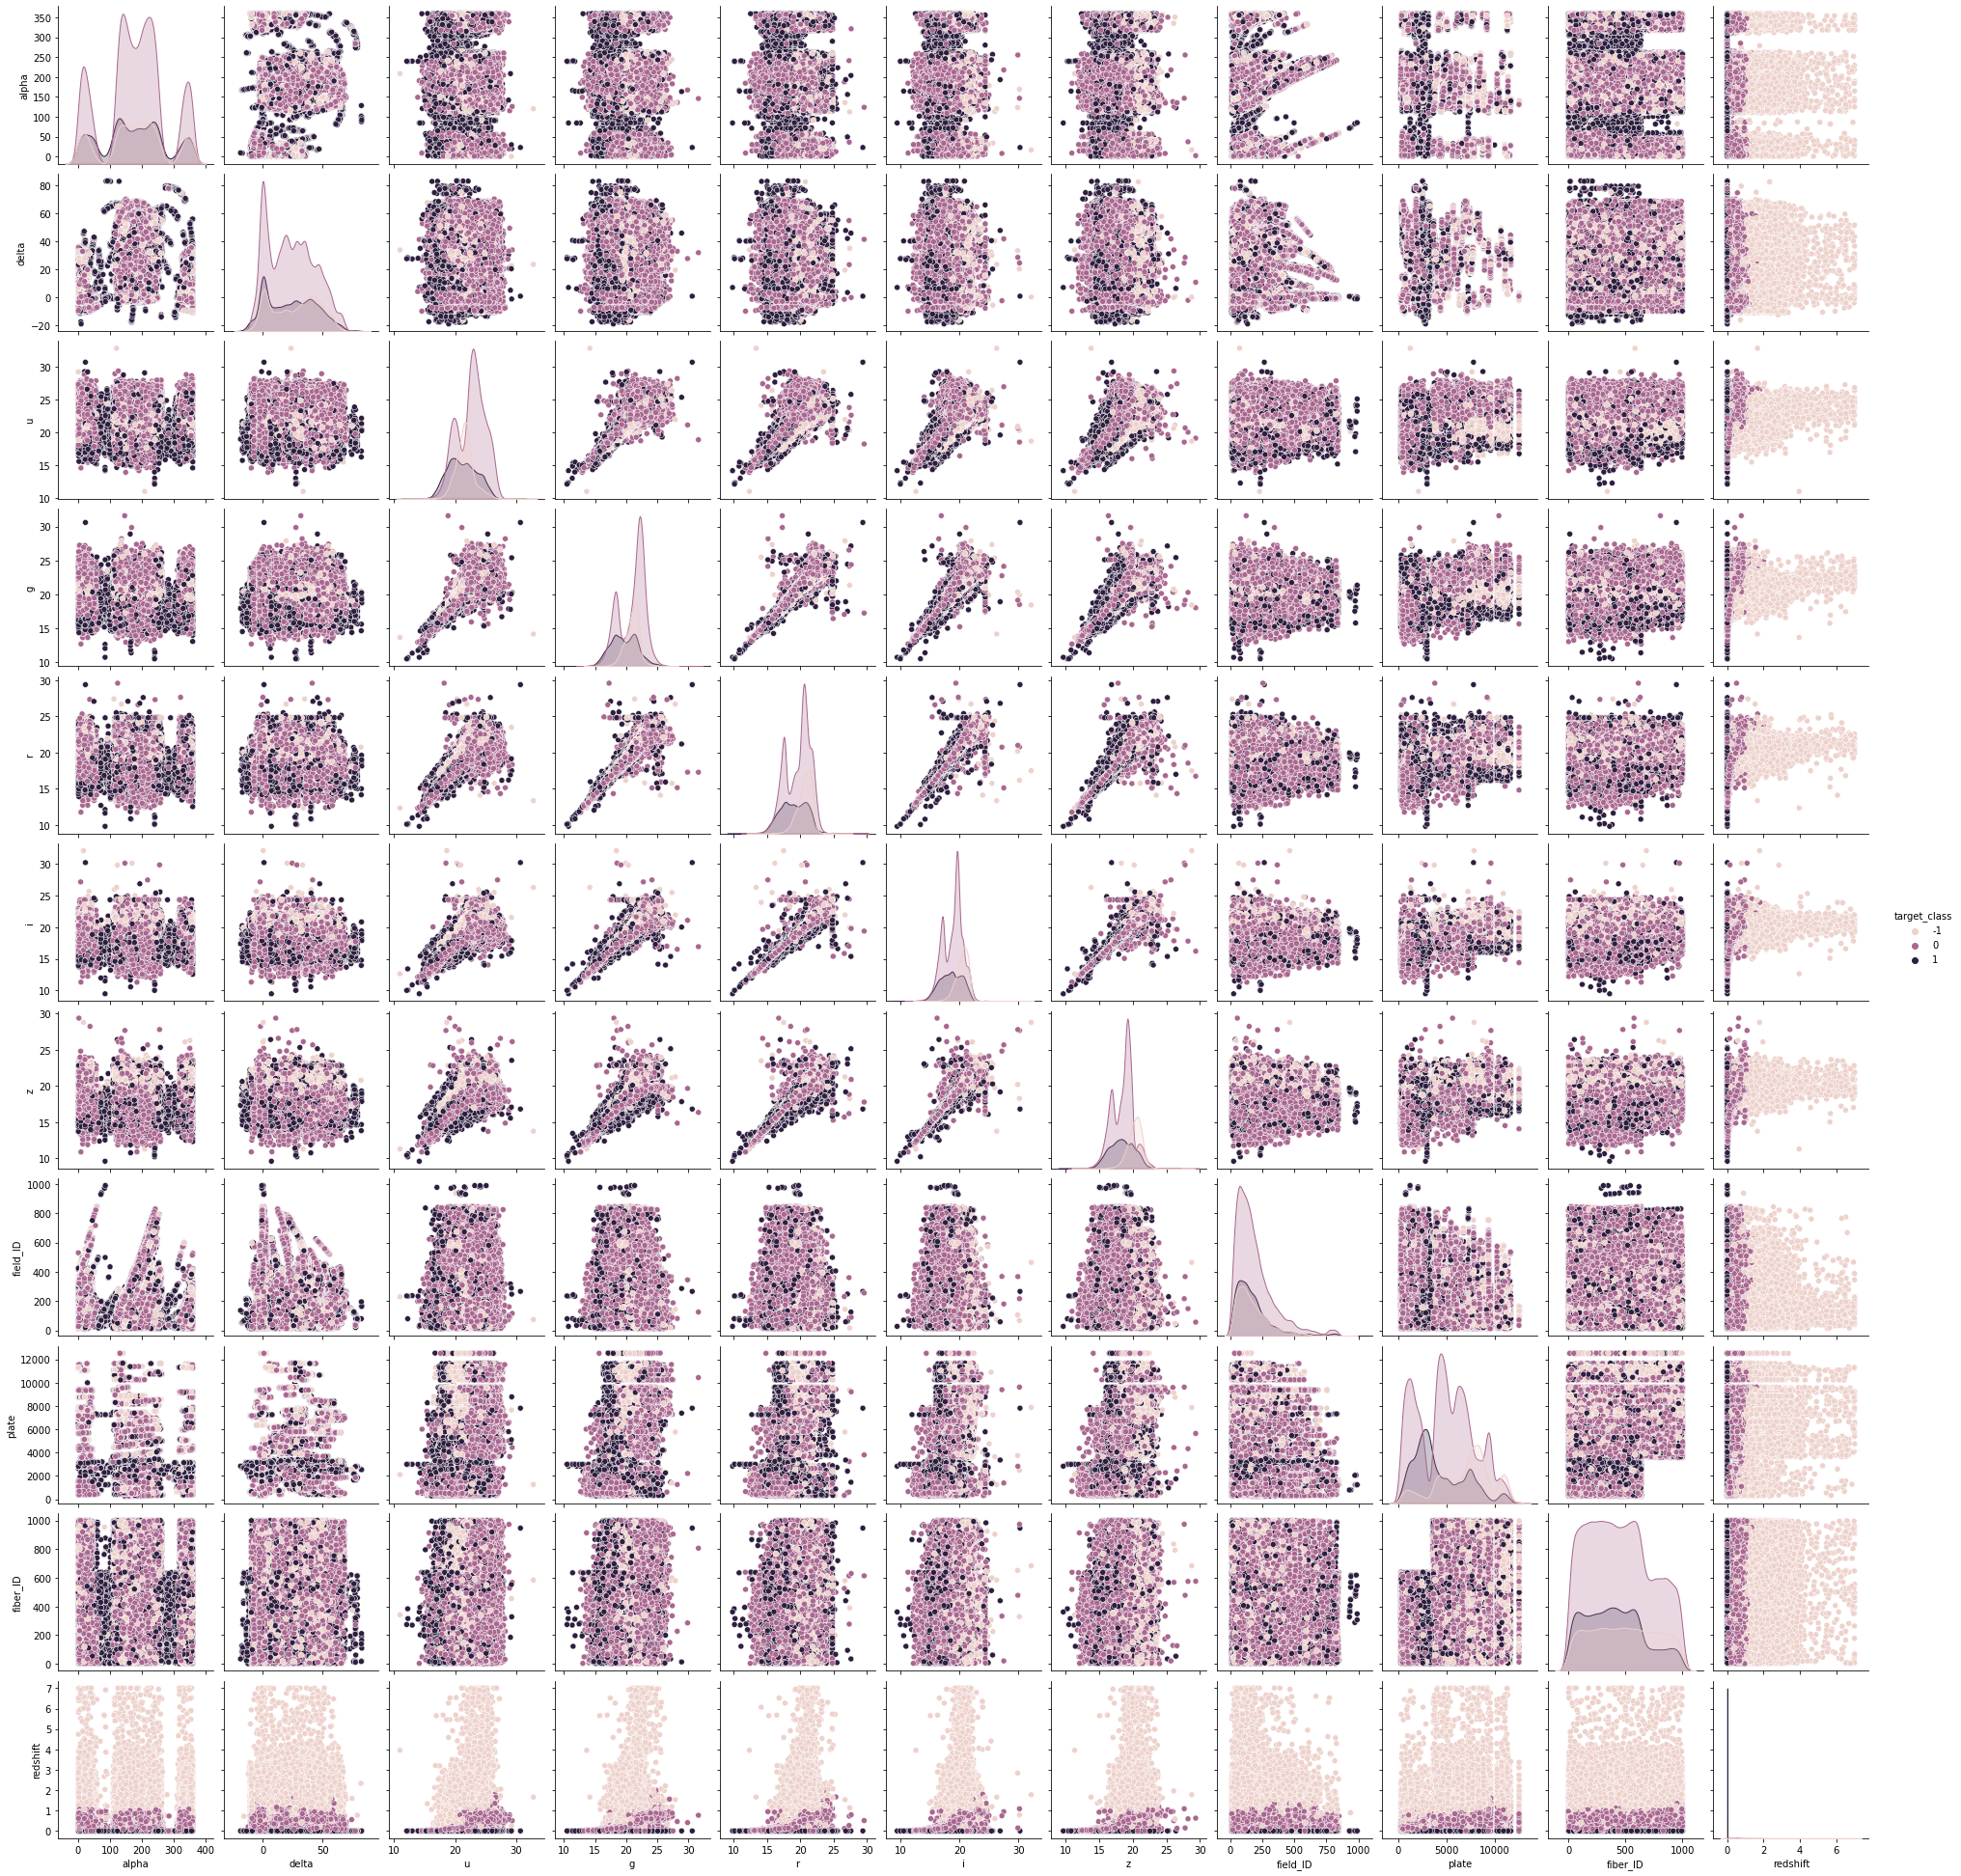

In [122]:
#plot up a quick pairplot (not so quick because of the size of the data--make quicker with sample subset)
#See what correlations might exist! Color scheme is based on the Target Class column
sns.pairplot(df, hue="target_class")

Redshift may be a good variable to begin classification and may help with choosing binary classes for mvp-stage of project 

We see colinearity among the five columns with single letter names. 
Colinearity is not much of a concern in logistic regression. 

Random Forest will handle dispersions from colinearity well. There is indeed some dispersion and it is worth keeping all of the suspected colinear columns. (If there is perfect colinearity, the extra data wont help the model, but here, the dispersion could be important). 

In [124]:
#Let's look at redshift a little closer
df2_redshift = df[['redshift','target_class']]
print("Star",df2_redshift.loc[df2_redshift['target_class']== 1].describe())
print("Galaxy", df2_redshift.loc[df2_redshift['target_class']== 0].describe())
print("Quasar", df2_redshift.loc[df2_redshift['target_class']== -1].describe())

Star            redshift  target_class
count  21593.000000       21593.0
mean      -0.000115           1.0
std        0.000465           0.0
min       -0.004136           1.0
25%       -0.000295           1.0
50%       -0.000076           1.0
75%        0.000075           1.0
max        0.004153           1.0
Galaxy            redshift  target_class
count  59445.000000       59445.0
mean       0.421596           0.0
std        0.264858           0.0
min       -0.009971           0.0
25%        0.164527           0.0
50%        0.456274           0.0
75%        0.594699           0.0
max        1.995524           0.0
Quasar            redshift  target_class
count  18961.000000       18961.0
mean       1.719676          -1.0
std        0.913954           0.0
min        0.000461          -1.0
25%        1.106605          -1.0
50%        1.617232          -1.0
75%        2.220279          -1.0
max        7.011245          -1.0


**Quasars** have the highest *max, mean* and *min*. They are the smallest class size. 
There is very little overlap between Quasar and Star, making a binary model with those two classes pretty easy.
Let's choose a tougher problem and look at the other two classes.

The **Star** *min* and *mean* are negative, and the max is larger than the min of the other two. 
The redshift values in the range of -0.009971 to 2 are the most ambiguous.. and will be the tricky stuff to resolve

The **Galaxy** *min* is negative too. The *max* is less than two. 

It seems that if:
- redshift is > 2 (maybe even >1), object is a **quasar**. 
- redshift is at roughly: 0 or less, object is a **star** 
- redshift of 0-1, object is a **galaxy**, is my guess.

#### Remove **Quasar** from dataset for the first round of model building

In [136]:
#Establish the binary dataset by excluding quasars 
df_binary = df[df['class'] != 'QSO']

#Remove 'class' to have all continuous data for modeling
df_binary = df_binary.loc[:, df_binary.columns!='class']


# Check the result
df_binary.sample(10)

alpha      delta         u         g         r         i  \
84800  167.097749  49.017852  24.92249  22.20245  20.75245  19.80836   
50413  183.300128  42.095055  22.05303  21.53496  21.47317  21.60868   
88921    5.549145  -9.695051  19.62779  17.11389  15.94914  15.51025   
60790   27.275307  23.193375  21.89678  21.65961  21.98560  21.86224   
63023  172.376281  18.753389  24.87906  22.28115  20.55798  19.46342   
55662   50.650864   6.404584  19.09070  17.39102  16.61848  16.30179   
91769   35.131677   4.017564  23.63326  22.30485  20.55402  19.76169   
9134   166.766990   3.793669  19.13616  18.09237  17.63089  17.45855   
48556  155.822129  47.520330  23.17101  21.73828  20.40378  19.29359   
24814  124.833067  38.754340  24.33840  21.59698  20.43385  19.98714   

              z  field_ID  plate  fiber_ID  redshift  target_class  
84800  19.58015       244   6693       865  0.499895             0  
50413  21.46326       167   6633       540  0.000153             1  
88921  15.28278        59   1912       467 -0.000081             1  
60790  23.08584        38   7638       154  0.045012             0  
63023  18.97495        87   5879       377  0.535807             0  
55662  16.11155       210   2334       363 -0.000059             1  
91769  19.30480       300   4264       289  0.489916             0  
9134   17.41600       317   3243       535  0.000719             1  
48556  18.97287       292   6658       201  0.602596             0  
24814  19.81427       130   9361       202 -0.000054             1

## Explore the data with a baseline logistic regression model and ROC AUC plot. 

In [137]:
# Create separate df's with X as explanatory variables of interest and y as the dependent variable, class(boolean)
X_binary = df_binary.loc[:, df_binary.columns!='target_class']
y_binary = df_binary[['target_class']]

In [ ]:
# Split baseline data(bln) into train and test data at 30% test size, and arbitrary random state
X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size = .3, random_state = 42)

/Users/vesper/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vesper/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC AUC score =  0.771891652720853


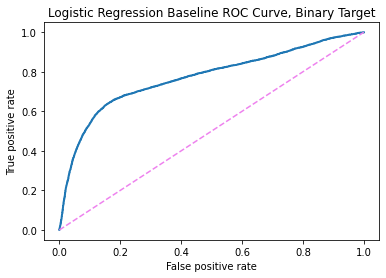

In [140]:
# Define the model, setting C so regularization is negligable at this stage
lr_baseline = LogisticRegression(C=1000)
# Fit the model to the training data
lr_baseline.fit(X_train, y_train)

#Now test the model on hold out data
#fpr = False positive rate, tpr = True positive rate, thresholds are the default 0.5
fpr, tpr, thresholds = roc_curve(y_test, lr_baseline.predict_proba(X_bln_test)[:,1])

#Plot the roc curve 
plt.plot(fpr, tpr,lw=2) #the model results, line weight 2
plt.plot([0,1],[0,1],c='violet',ls='--') #the "chance" line
plt.xlim([-0.05,1.05]) #bounds on plot
plt.ylim([-0.05,1.05])

#Gussy up the plot and save for presentation
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression Baseline ROC Curve, Binary Target');
print("ROC AUC score = ", roc_auc_score(y_bln_test, lr_baseline.predict_proba(X_bln_test)[:,1]))
plt.savefig("roc_auc_log_regression_baseline_bool")

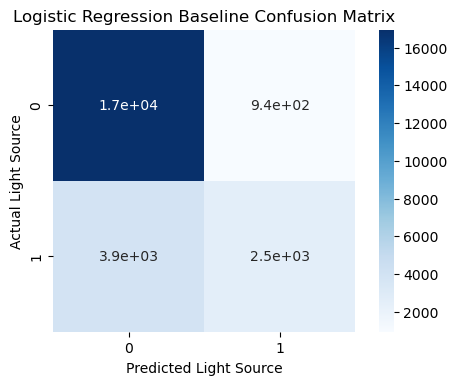

In [141]:
# Print confusion matrix for baseline (bln) results
y_pred_bln = (lr_baseline.predict(X_test)) #the model-predicted y values 

lr_bln_confusion = confusion_matrix(y_test, y_pred_bln) #the hold-out values vs the predicted values
plt.figure(dpi=100)
sns.heatmap(lr_bln_confusion, cmap = plt.cm.Blues, annot=True, square=True)
plt.xlabel('Predicted Light Source')
plt.ylabel('Actual Light Source')
plt.title('Logistic Regression Baseline Confusion Matrix');

plt.savefig("confusion_matrix_lr_baseline_bool") #save image for presentation

## Begin Model Building

### k-Nearest Neighbors

In [148]:
#Create a pipeline for the first model, k-Nearest Neighbor, to include a data scaler and model for parameter grid in next step
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNN())])

#Create a dictionary "grid" of parameters to test for the best performing ones. 
    #Testing:
    #Which data scaler performs best,
    #the best number of neighbors for clustering in model, 
    #and which weight application is best
knn_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              # we named the second step knn, so we have to use that name here
              'knn__n_neighbors': range(1, 100),
             'knn__weights': ('uniform', 'distance')}

#Create model grid to include the pipe above, the parameter grid, the cross-validation folds, and the metric of choice
    #n_jobs = -1 is chosen to use all processers, not running another job in parallel
    #RandomizedSearchCV first because it is faster. Will zero in on next step with GridSearchCV
    #ROC_AUC is used because the data is not heavily imbalanced and ultimately parameter ranking is not needed. 
    #Recall might also be key and worth obtaining because we would like to minimize false negatives 
knn_rand = RandomizedSearchCV(knn_pipe, knn_param_grid, cv=5, n_jobs = -1, random_state = 42, scoring = 'roc_auc')

#Fit the model to the data, flattening y into 1-D array
knn_rand.fit(X_train, y_train.values.ravel())

print('Best parameters:', knn_rand.best_params_)
print('ROC AUC score:', knn_grid.score(X_test, y_test))

Best parameters: {'scaler': StandardScaler(), 'knn__weights': 'distance', 'knn__n_neighbors': 14}
ROC AUC score: 0.9900258061905708


In [149]:
#Zero in on the best n_neighbors parameter. With RandomSearch CV, n_neighbors=14 was best performing. 
    #Look now at the values near to 14 (10-20) using GridSearchCV
knn_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              # we named the second step knn, so we have to use that name here
              'knn__n_neighbors': range(10,20),
             'knn__weights': ('uniform', 'distance')}

knn_grid = GridSearchCV(knn_pipe, knn_param_grid, cv=5, n_jobs = -1, scoring = 'roc_auc')
knn_grid.fit(X_train, y_train.values.ravel())
print('Best parameters:', knn_grid.best_params_)
print('ROC AUC score:', knn_grid.score(X_test, y_test))

/Users/vesper/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'knn__n_neighbors': 15, 'knn__weights': 'distance', 'scaler': StandardScaler()}
ROC AUC score: 0.9900183751910774


#### kNN model results:
Parameters of choice were:
- Standard Scaler
- Distance weighting
- 15 n-neighbors

..producing an **ROC_AUC of 0.9900**

### Logistic Regression

In [155]:
#Now repeat with Logistic Regression **This model runs very quickly!**
    #use a large max number of interations for convergance because error message required it
logres_pipe = Pipeline([('scaler', StandardScaler()), ('logres', LogisticRegression(max_iter = 1000))])

logres_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              'logres__C': np.arange(0.01, 100, 0.01),
             'logres__class_weight': ('balanced', 'none'),
                    #'logres__max_iter': range(100-100000)
                    }

logres_rand = RandomizedSearchCV(logres_pipe, logres_param_grid, cv=5, n_jobs = -1, random_state = 42, scoring = 'roc_auc')
logres_rand.fit(X_train, y_train.values.ravel())

print(logres_rand.best_params_)
print('ROC AUC score:', logres_rand.score(X_test, y_test))

{'scaler': StandardScaler(), 'logres__class_weight': 'none', 'logres__C': 40.06}
ROC AUC score: 0.9967954380276178


In [157]:
#Now zero in on best C value (inverse of regularization strength) for this model
logres_pipe = Pipeline([('scaler', StandardScaler()), ('logres', LogisticRegression(max_iter = 1000))])

logres_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              'logres__C': np.arange(38, 42, 0.01),
             'logres__class_weight': ('balanced', 'none'),
                    }

logres_grid = GridSearchCV(logres_pipe, logres_param_grid, cv=5, n_jobs = -1, scoring = 'roc_auc')
logres_grid.fit(X_train, y_train.values.ravel())
print(logres_grid.best_params_)
print('ROC AUC score:', logres_grid.score(X_test, y_test))

{'logres__C': 41.989999999999206, 'logres__class_weight': 'none', 'scaler': StandardScaler()}
ROC AUC score: 0.9967990404091053


#### Logistic Regression model results:
Parameters of choice were:
- Standard Scaler
- No weighting
- Cost function of 41.99

..producing an **ROC_AUC of 0.9967** (slightly better than kNN)


### Random Forest

In [163]:
#Now build the pipeline and model for Random Forest
rf_pipe = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

#Establish the parameter options tested in the Random Search CV:
    # Number of features to consider at every split
max_features = ['log2', 'sqrt', None]
    # Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
    # Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
    # Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

rf_param_rand = {'scaler': [MinMaxScaler(), StandardScaler()],
              'rf__max_features': max_features,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__n_estimators': n_estimators,
              'rf__max_depth': max_depth,
                }

rf_rand = RandomizedSearchCV(rf_pipe, rf_param_rand, cv=5, n_jobs = -1, random_state = 42, scoring = 'roc_auc')
rf_rand.fit(X_train, y_train.values.ravel())

print(rf_rand.best_params_)
print('ROC AUC score:', rf_rand.score(X_test, y_test))

{'scaler': MinMaxScaler(), 'rf__n_estimators': 400, 'rf__min_samples_leaf': 4, 'rf__max_features': 'sqrt', 'rf__max_depth': 30}
ROC AUC score: 0.9996878197086377


In [168]:
#Same as above, now zeroing in on The hyper parameters using Gridsearch CV
rf_pipe = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])


max_features = ['log2', 'sqrt', None]
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 500, num = 10)]
max_depth = [int(x) for x in np.linspace(1, 10, num = 1)]
#max_depth.append(None)
#min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

rf_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              'rf__max_features': max_features,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__n_estimators': n_estimators,
              'rf__max_depth': max_depth,
                }

rf_grid = GridSearchCV(rf_pipe, rf_param_grid, cv=5, n_jobs = -1, scoring = 'roc_auc')
rf_grid.fit(X_train, y_train.values.ravel())
print(rf_grid.best_params_)
print('ROC AUC score:', rf_grid.score(X_test, y_test))


{'rf__max_depth': 1, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__n_estimators': 411, 'scaler': StandardScaler()}
ROC AUC score: 0.9965774199856907


**These results should be better than first run, but they are not. Explore this further.**

#### Random Forest model results:  ****
Parameters of choice were:
- Standard Scaler
- n_estimaators of 411
- max depth of 3
- max features of sqrt

..producing an **ROC_AUC of 0.9997** (slightly better than both other models)


## Exploring Feature Selection

In [65]:
#Trying the model on just the photometric fields. 
#Can the dispersion in the photometric data alone be used to classify the objects?
X_train_photometric = X_train[['u', 'g', 'r', 'i', 'z']]
X_test_photometric = X_test[['u', 'g', 'r', 'i', 'z']]

rf_pipe = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]#, 2, 4]

rf_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              'rf__max_features': max_features,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__n_estimators': n_estimators,
#              'rf__max_depth': max_depth,
                }

rf_grid = GridSearchCV(rf_pipe, rf_param_grid, cv=5, n_jobs = -1, scoring = 'roc_auc')
rf_grid.fit(X_train_photometric, y_train)
print(rf_grid.best_params_)
print('ROC AUC score:', rf_grid.score(X_test_photometric, y_test))
#output
# {'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__n_estimators': 1000, 'scaler': StandardScaler()}
# ROC AUC score: 0.9665974223394203

{'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__n_estimators': 1000, 'scaler': StandardScaler()}
ROC AUC score: 0.9665974223394203


- alpha 0.5763630013073437
- delta 0.5762262267990943
- u 0.5400399832000615
- g 0.5425730279723301
- r 0.5654961887854988
- i 0.57324069023966
- z 0.5757901854691938
- field_ID 0.5757931609773025
- plate 0.5715024971264396
- fiber_ID 0.5741450919073944
- redshift 0.030180014897803926

(double check this to be sure up to date)

#### Now I will use my best model-- Random Forest, with: 
- max_features': 'sqrt'  
- min_samples_leaf': 4 
- n_estimators': 944, 
- 'scaler': MinMaxScaler() 

Which obtained ROC AUC score: 0.9996541670265061

Fit it on all the data, without CV, and see how well the model performs. 

In [104]:
#from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
rf_final = RandomForestClassifier(max_features = 'sqrt', n_estimators = 944, min_samples_leaf = 4, n_jobs = -1, random_state = 42)
rf_final.fit(X_train, y_train)
y_pred = (rf_final.predict(X_ho))
print(f1_score(y_ho,y_pred))
#0.9475661548513558
#0.020030816640986136
#0.9955824226923972 my model fit on all the data and tested on the holdout data


print("roc:",roc_auc_score(y_ho,y_pred))
print("precision:",precision_score(y_ho,y_pred))
print("recall:",recall_score(y_ho,y_pred))
print("F1:", f1_score(y_ho,y_pred))
print(confusion_matrix(y_ho, y_pred))


0.9955824226923972
roc: 0.9983069285586406
precision: 0.9915097252238345
recall: 0.9996887159533074
F1: 0.9955824226923972
[[17832    55]
 [    2  6423]]


In [116]:
df3 = df1[df1['class']!="QSO"]
df3

alpha      delta         u         g         r         i  \
0      135.689107  32.494632  23.87882  22.27530  20.39501  19.16573   
1      144.826101  31.274185  24.77759  22.83188  22.58444  21.16812   
2      142.188790  35.582444  25.26307  22.66389  20.60976  19.34857   
3      338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454   
4      345.282593  21.183866  19.43718  17.58028  16.49747  15.97711   
...           ...        ...       ...       ...       ...       ...   
99995   39.620709  -2.594074  22.16759  22.97586  21.90404  21.30548   
99996   29.493819  19.798874  22.69118  22.38628  20.45003  19.75759   
99997  224.587407  15.700707  21.16916  19.26997  18.20428  17.69034   
99998  212.268621  46.660365  25.35039  21.63757  19.91386  19.07254   
99999  196.896053  49.464643  22.62171  21.79745  20.60115  20.00959   

              z  field_ID  plate  fiber_ID  redshift   class  class_bool  
0      18.79371        79   5812       171  0.634794  GALAXY           0  
1      21.61427       119  10445       427  0.779136  GALAXY           0  
2      18.94827       120   4576       299  0.644195  GALAXY           0  
3      19.25010       214   9149       775  0.932346  GALAXY           0  
4      15.54461       137   6121       842  0.116123  GALAXY           0  
...         ...       ...    ...       ...       ...     ...         ...  
99995  20.73569       581   9374       438  0.000000  GALAXY           0  
99996  19.41526       289   7626       866  0.404895  GALAXY           0  
99997  17.35221       308   2764        74  0.143366  GALAXY           0  
99998  18.62482       131   6751       470  0.455040  GALAXY           0  
99999  19.28075        60   7410       851  0.542944  GALAXY           0  

[81038 rows x 13 columns]

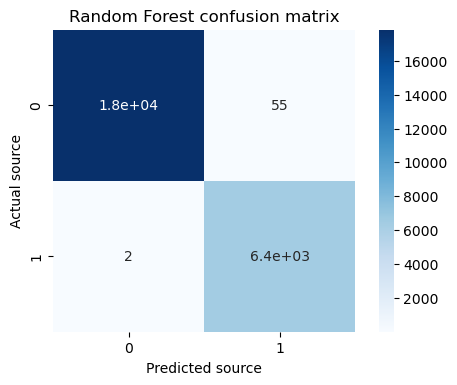

In [119]:
# Print confusion matrix for random forest final model
rf_final_confusion = confusion_matrix(y_ho, y_pred)
plt.figure(dpi=100)
sns.heatmap(rf_final_confusion, cmap=plt.cm.Blues, annot=True, square=True),
#           xticklabels=df3['class'],
#           yticklabels=df3['class'])

plt.xlabel('Predicted source')
plt.ylabel('Actual source')
plt.title('Random Forest confusion matrix');

plt.savefig("confusion_matrix_rf_final_bool")

### 0.9955824226923972

In [133]:
fpr, tpr, thresholds = roc_curve(y_ho, rf_final.predict_proba(X_ho)[:,1])

ROC AUC score =  0.9996425637035266


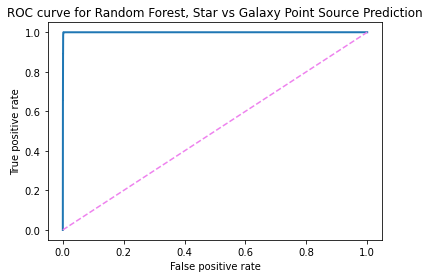

In [134]:
fpr, tpr, thresholds = roc_curve(y_ho, rf_final.predict_proba(X_ho)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Random Forest, Star vs Galaxy Point Source Prediction');
print("ROC AUC score = ", roc_auc_score(y_ho, rf_final.predict_proba(X_ho)[:,1]))
plt.savefig("roc_auc_rf_final_bool")

#### now try multiclass

In [152]:
y_mult.tail()

99996                                                   GALAXY
99997                                                   GALAXY
99998                                                   GALAXY
99999                                                   GALAXY
class_num    [0, 0, 0, 0, 0, 1, 1, 0, 0, -1, 0, 0, -1, 0, 0...
Name: class, dtype: object

In [165]:
#https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
# create a list of our conditions
conditions = [
    (df['class'] == 'STAR'),
    (df['class'] == 'GALAXY'),
    (df['class'] == 'QSO'),
    ]

# create a list of the values we want to assign for each condition
values = [-1, 0, 1]

# create a new column and use np.select to assign values to it using our lists as arguments
y_mult['class_num'] = np.select(conditions, values)

# display updated DataFrame
y_mult.tail()

#y_mult['class_num'] = df['class'].apply(lambda series: label_source(series))#, axis=1)
       

99996                                                   GALAXY
99997                                                   GALAXY
99998                                                   GALAXY
99999                                                   GALAXY
class_num    [0, 0, 0, 0, 0, 1, 1, 0, 0, -1, 0, 0, -1, 0, 0...
Name: class, dtype: object

In [175]:
y_mult.to_frame()# ['class_num'] = df['class'].apply(lambda series: label_source(series))#, axis=1)
y_mult['test'] = df['class']
y_mult
y_mult_df = pd.DataFrame
#y_mult_df['test'] = df['redshift']
type(y_mult_df)

type

### The following cell is the multi class model using the rf_fin for the binary trials

In [201]:
X_mult_a = df.loc[:, df.columns!='class']
X_mult = X_mult_a.loc[:, X_mult_a.columns!='class_int']
y_mult = df['class_int']


X_mult_train, X_mult_test, y_mult_train, y_mult_test = train_test_split(X_mult, y_mult, test_size = 0.3, random_state = 42)
y_mult_test.to_numpy()

rf_final = RandomForestClassifier(max_features = 'sqrt', n_estimators = 400, min_samples_leaf = 4, n_jobs = -1, random_state = 42)
rf_final.fit(X_mult_train, y_mult_train)
y_mult_pred = (rf_final.predict(X_mult_test))
print(f1_score(y_mult_test,y_mult_pred, average='macro'))

#print("roc:",roc_auc_score(y_mult_test,y_mult_pred, multi_class='ovr'))
print("precision:",precision_score(y_mult_test,y_mult_pred, average='macro'))
print("recall:",recall_score(y_mult_test,y_mult_pred, average='macro'))
print("F1:", f1_score(y_mult_test,y_mult_pred, average='macro'))
print(confusion_matrix(y_mult_test,y_mult_pred))


0.9742071368816392
precision: 0.9779386406860971
recall: 0.9707674075518405
F1: 0.9742071368816392
[[ 5320   422     0]
 [  191 17574    51]
 [    0     4  6438]]


In [222]:
df.value_counts('class')

class
GALAXY    59445
STAR      21593
QSO       18961
dtype: int64

* precision: 0.9779386406860971
* recall: 0.9707674075518405
### * F1: 0.9742071368816392
* [[ 5320   422     0]
* [  191 17574    51]
* [    0     4  6438]]

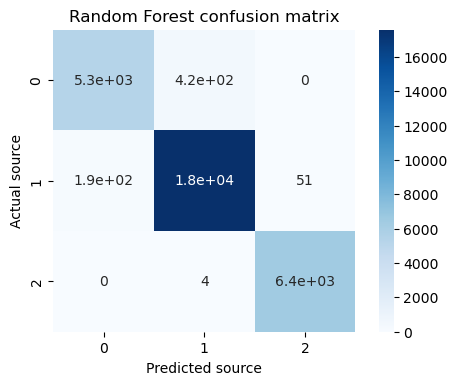

In [204]:
# Print confusion matrix for random forest final model
rf_final_multi_confusion = confusion_matrix(y_mult_test,y_mult_pred)
plt.figure(dpi=100)
sns.heatmap(rf_final_multi_confusion, cmap=plt.cm.Blues, annot=True, square=True),
#           xticklabels=df3['class'],
#           yticklabels=df3['class'])

plt.xlabel('Predicted source')
plt.ylabel('Actual source')
plt.title('Random Forest confusion matrix');

plt.savefig("confusion_matrix_rf_final_multi")

### Now try just redshift

In [207]:
X_red = df.loc[:, df.columns =='redshift']
y_red = df['class_int']


X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, test_size = 0.3, random_state = 42)
y_red_test.to_numpy()

rf_final = RandomForestClassifier(max_features = 'sqrt', n_estimators = 400, min_samples_leaf = 4, n_jobs = -1, random_state = 42)
rf_final.fit(X_red_train, y_red_train)
y_red_pred = (rf_final.predict(X_red_test))
#print(f1_score(y_red_test,y_red_pred, average='macro'))

#print("roc:",roc_auc_score(y_mult_test,y_mult_pred, multi_class='ovr'))
print("precision:",precision_score(y_red_test,y_red_pred, average='macro'))
print("recall:",recall_score(y_red_test,y_red_pred, average='macro'))
print("F1:", f1_score(y_red_test,y_red_pred, average='macro'))
print(confusion_matrix(y_red_test,y_red_pred,))

#top row 5742    star
#mid row 17816   galaxy
#bottom row 6442  quasar

# no qso misclassified as stars and vice versa. 
# 1210 stars misclassified as galaxies
#397 galaxies misclassified as stars and 25 galaxies misclassified as qso
#7 qso misclassified as galaxies

precision: 0.9500649583170452
recall: 0.9214996125742502
F1: 0.9339768652801662
[[ 4532  1210     0]
 [  397 17394    25]
 [    0     7  6435]]


In [218]:
y_red_test.to_frame().value_counts()

class_int
 0           17816
 1            6442
-1            5742
dtype: int64

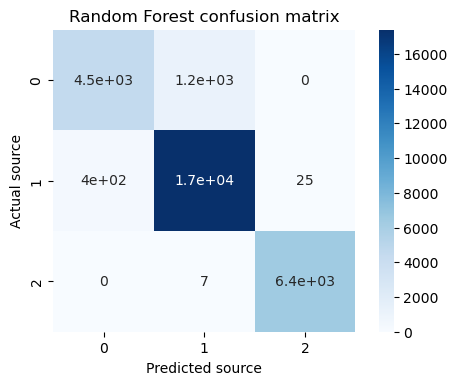

In [208]:
# Print confusion matrix for random forest final model
rf_final_red_confusion = confusion_matrix(y_red_test,y_red_pred)
plt.figure(dpi=100)
sns.heatmap(rf_final_red_confusion, cmap=plt.cm.Blues, annot=True, square=True),
#           xticklabels=df3['class'],
#           yticklabels=df3['class'])

plt.xlabel('Predicted source')
plt.ylabel('Actual source')
plt.title('Random Forest confusion matrix');

plt.savefig("confusion_matrix_rf_final_red")

In [160]:
#from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
rf_pipe = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

rf_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              'rf__max_features': max_features,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__n_estimators': n_estimators,
#              'rf__max_depth': max_depth,
                }

rf_grid = RandomizedSearchCV(rf_pipe, rf_param_grid, cv=5, n_jobs = -1, random_state = 42, scoring = 'roc_auc')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_params_)
print('ROC AUC score:', rf_grid.score(X_ho, y_ho))


{'scaler': MinMaxScaler(), 'rf__n_estimators': 400, 'rf__min_samples_leaf': 2, 'rf__max_features': 'auto'}
ROC AUC score: 0.9996360245980007


### {'scaler': MinMaxScaler(), 'rf__n_estimators': 400, 'rf__min_samples_leaf': 2, 'rf__max_features': 'auto'}
### ROC AUC score: 0.9996360245980007

In [162]:
#from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
rf_pipe = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

rf_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              'rf__max_features': max_features,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__n_estimators': n_estimators,
#              'rf__max_depth': max_depth,
                }

rf_grid = GridSearchCV(rf_pipe, rf_param_grid, cv=5, n_jobs = -1, scoring = 'roc_auc')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_params_)
print('ROC AUC score:', rf_grid.score(X_ho, y_ho))


{'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__n_estimators': 766, 'scaler': StandardScaler()}
ROC AUC score: 0.9996585046766786


### {'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__n_estimators': 766, 'scaler': StandardScaler()}
### ROC AUC score: 0.9996585046766786

#### the n_estimators range dramatically. what can I say about that?

--------------------------------------------------

In [178]:
# create a list of our conditions
conditions = [
    (df['class'] == 'STAR'),
    (df['class'] == 'GALAXY'),
    (df['class'] == 'QSO'),
     ]

# create a list of the values we want to assign for each condition
values = [1, 0, -1]

# create a new column and use np.select to assign values to it using our lists as arguments
df['class_int'] = np.select(conditions, values)

# display updated DataFrame
df.describe()

alpha         delta             u             g             r  \
count  99999.000000  99999.000000  99999.000000  99999.000000  99999.000000   
mean     177.628653     24.135552     22.080679     20.631583     19.645777   
std       96.502612     19.644608      2.251068      2.037384      1.854763   
min        0.005528    -18.785328     10.996230     10.498200      9.822070   
25%      127.517698      5.147477     20.352410     18.965240     18.135795   
50%      180.900527     23.646462     22.179140     21.099930     20.125310   
75%      233.895005     39.901582     23.687480     22.123775     21.044790   
max      359.999810     83.000519     32.781390     31.602240     29.571860   

                  i             z      field_ID         plate      fiber_ID  \
count  99999.000000  99999.000000  99999.000000  99999.000000  99999.000000   
mean      19.084865     18.768988    186.127011   5137.027890    449.315613   
std        1.757900      1.765982    149.007687   2952.312485    272.498252   
min        9.469903      9.612333     11.000000    266.000000      1.000000   
25%       17.732280     17.460830     82.000000   2526.000000    221.000000   
50%       19.405150     19.004600    146.000000   4987.000000    433.000000   
75%       20.396510     19.921120    241.000000   7400.500000    645.000000   
max       32.141470     29.383740    989.000000  12547.000000   1000.000000   

           redshift     class_int  
count  99999.000000  99999.000000  
mean       0.576667      0.026320  
std        0.730709      0.636282  
min       -0.009971     -1.000000  
25%        0.054522      0.000000  
50%        0.424176      0.000000  
75%        0.704172      0.000000  
max        7.011245      1.000000

In [22]:
df.class_int.value_counts()

 0    59445
-1    21593
 1    18961
Name: class_int, dtype: int64

In [23]:
#redefine X and y for the numeric class column
X = df.loc[:, df.columns!=('class', 'class_int')]
y = df['class_int']

In [117]:
lr_model_all = LogisticRegression(C=1000)
lr_model_all.fit(X_train_scaled_df, yb_train1)
y_prob_pred_test = lr_model_all.predict_proba(X_test_scaled_df)[:,1]
y_pred_test = lr_model_all.predict(X_val)#[:,1]
print(log_loss(yb_val,y_prob_pred_test))
print(accuracy_score(yb_val,y_pred_test))

0.022592372627748162
0.7852380952380953


I'm trying to run a quick model to see which variable might do better ('u' vs 'z'--maybe try the others too).

With u, the log loss was 0.0227 and accuracy score was 0.78. With z the log loss was 0.0225 and accuracy was 0.78524